In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from pathlib import Path
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import cv2

# CRATERI:
# config_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/Cascade_Mask_RCNN.py'
# checkpoint_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/epoch_10.pth'

# RETINASWIN MULTIWAKE:
config_file = 'checkpoints/B4/retina_swin/retina_swin_2022-07-28T22:15:36_768_50e_B4_lr_0.001_step/retinanet_swin-t-p4-w7_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/B4/retina_swin/retina_swin_2022-07-28T22:15:36_768_50e_B4_lr_0.001_step/epoch_44.pth'


# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

load checkpoint from local path: checkpoints/B4/retina_swin/retina_swin_2022-07-28T22:15:36_768_50e_B4_lr_0.001_step/epoch_44.pth


In [2]:
import os
import fiftyone as fo

IMAGES_DIR='data/DATASETS/SARWake/val2017'
JSON_PATH='data/DATASETS/SARWake/annotations/instances_val2017.json'
LABEL='wake'
# Load COCO formatted dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=IMAGES_DIR,
    labels_path=JSON_PATH,
    include_id=True,
    label_field=LABEL,)
# Verify that the class list for our dataset was imported
# print(coco_dataset.default_classes)  # ['airplane', 'apple', ...]
print(dataset)

 100% |███████████████████| 61/61 [92.7ms elapsed, 0s remaining, 657.8 samples/s]  
Name:        2023.01.29.16.04.45
Media type:  image
Num samples: 61
Persistent:  False
Tags:        []
Sample fields:
    id:              fiftyone.core.fields.ObjectIdField
    filepath:        fiftyone.core.fields.StringField
    tags:            fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:        fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    wake_detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    wake_coco_id:    fiftyone.core.fields.IntField


In [7]:
# img_path = Path('data/DATASETS/Craters/val2017/539.jpg')
# img = cv2.imread(img_path.as_posix())
# shape = mmcv.imread(img_path).shape

# result = inference_detector(model, img)
# img = cv2.imread('/home/sirbastiano/Scaricati/tree-736885__480.jpg')

# type(img)
# img.shape
# boxes, masks = result
# plt.imshow(masks[0][5])
# len(boxes[0])
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# fig,ax = plt.subplots(figsize=(10,10))
# ax.imshow(img)
# for item in boxes[0]:
#      X=item
#      topleft = [X[0],X[1]]
#      botright = [X[2],X[3]]
#      score=X[4]

#      rect = patches.Rectangle((topleft[0], topleft[1]), botright[0]-topleft[0], botright[1]-topleft[1], linewidth=3, edgecolor='r', facecolor='none')
#      ax.add_patch(rect)
# plt.show()
# import fiftyone as fo
segmentation = False

for sample in dataset:
    # sample = fo.Sample(filepath="data/DATASETS/Craters/val2017/539.jpg")
    # img = cv2.imread("data/DATASETS/Craters/val2017/539.jpg")
    img = cv2.imread(sample.filepath)
    h,w,c=img.shape
    result = inference_detector(model, img)

    if segmentation:
        boxes, masks = result # if instance segmentation method
    else:
        boxes = result

    X = boxes[0]
    sample["RetinaSwin"] = fo.Detections(
        detections=[
            fo.Detection(label=LABEL, confidence=X[4], bounding_box=[X[0]/w, X[1]/h, X[2]/w-X[0]/w, X[3]/h-X[1]/h]) for X in boxes[0]
        ]
    )
    sample.save()
    
    # print(sample)
    # dataset.add_sample(sample)

In [3]:
session = fo.launch_app(dataset)

In [18]:
from fiftyone import ViewField as F

# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels("RetinaSwin", F("confidence") > 0.65)

In [19]:
# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    "RetinaSwin",
    gt_field=f"{LABEL}_detections",
    eval_key="eval",
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 106/106 [483.2ms elapsed, 0s remaining, 219.4 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 106/106 [420.9ms elapsed, 0s remaining, 251.9 samples/s]      


In [20]:
# Get the 10 most common classes in the dataset
counts = dataset.count_values(f"{LABEL}_detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)
print('Mean Average Precision:' results.mAP())

              precision    recall  f1-score   support

        wake       0.87      0.66      0.75       170

   micro avg       0.87      0.66      0.75       170
   macro avg       0.87      0.66      0.75       170
weighted avg       0.87      0.66      0.75       170



In [21]:
plot = results.plot_pr_curves(classes=[LABEL])
plot.show()

AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

FigureWidget({
    'data': [{'customdata': array([0.9957419 , 0.99383474, 0.99146661, 0.98495588, 0.89157026, 0.88999532,
                                   0.88798772, 0.88709199, 0.8827724 , 0.87791806, 0.87617657, 0.87180204,
                                   0.85083978, 0.77349021, 0.77151534, 0.76690738, 0.76067628, 0.75286566,
                                   0.7442785 , 0.73021269, 0.724032  , 0.64069299, 0.63253642, 0.62843219,
                                   0.61977038, 0.54788114, 0.53895555, 0.53365791, 0.52932104, 0.51505776,
                                   0.50923984, 0.49969929, 0.49313012, 0.48534493, 0.48233266, 0.47398528,
                                   0.40120777, 0.39698374, 0.3911122 , 0.38652654, 0.38364205, 0.37886943,
                                   0.30813382, 0.30557961, 0.30476995, 0.30134356, 0.29788642, 0.29599356,
                                   0.29242892, 0.22235138, 0.22209084, 0.22016376, 0.21764202, 0.21491349,
                                   0.21356583, 0.14443225, 0.14312679, 0.14287454, 0.14163703, 0.14022093,
                                   0.13947875, 0.13820993, 0.13675618, 0.06814812, 0.06790454, 0.0676688 ,
                                   0.06541213, 0.        , 0.        , 0.        , 0.        , 0.        ,
                                   0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
                                   0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
                                   0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
                                   0.        , 0.        , 0.        , 0.        , 0.        , 0.        ,
                                   0.        , 0.        , 0.        , 0.        , 0.        ]),
              'hovertemplate': ('<b>class: %{text}</b><br>recal' ... 'customdata:.3f}<extra></extra>'),
              'line': {'color': '#FF6D04'},
              'mode': 'lines',
              'name': 'wake (AP = 0.323)',
              'text': array(['wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake', 'wake',
                             'wake', 'wake'], dtype='<U4'),
              'type': 'scatter',
              'uid': 'cb32c165-2d91-424c-8f9f-c523b5a9b281',
              'x': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
                          0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23,
                          0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35,
                          0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47,
                          0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
                          0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
                          0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83,
   

In [ ]:
# from mmdet.apis import init_detector, inference_detector, show_result_pyplot
# from pathlib import Path
# import numpy as np
# import mmcv
# import matplotlib.pyplot as plt
# import cv2
# import os
# import fiftyone as fo
# from fiftyone import ViewField as F
# global LABEL, MODEL_NAME

# def model_load(model_cp, config):
#      model = init_detector(config, model_cp, device='cuda:0')
#      return model

# def dataset_parser(IMAGES_DIR,JSON_PATH,LABEL):
#      # Load COCO formatted dataset
#      dataset = fo.Dataset.from_dir(
#      dataset_type=fo.types.COCODetectionDataset,
#      data_path=IMAGES_DIR,
#      labels_path=JSON_PATH,
#      include_id=True,
#      label_field='GT',)
#      # Verify that the class list for our dataset was imported
#      # print(coco_dataset.default_classes)  # ['airplane', 'apple', ...]
#      print(dataset)
#      return dataset

# # MODEL
# CFG = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/Cascade_Mask_RCNN.py'
# CHP = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/epoch_10.pth'
# MODEL_NAME = 'Cascade_Mask_RCNN'
# model = model_load(model_cp=CHP, config=CFG)
# # DATASET
# IMAGES_DIR='data/DATASETS/Craters/val2017'
# JSON_PATH='data/DATASETS/Craters/annotations/instances_val2017.json'
# LABEL='crater'
# dataset = dataset_parser(IMAGES_DIR,JSON_PATH,LABEL)

# for sample in dataset:
#      # sample = fo.Sample(filepath="data/DATASETS/Craters/val2017/539.jpg")
#     # img = cv2.imread("data/DATASETS/Craters/val2017/539.jpg")
#     img = cv2.imread(sample.filepath)
#     h,w,c=img.shape
#     result = inference_detector(model, img)
#     boxes, masks = result
#     X = boxes[0]

#     sample[MODEL_NAME] = fo.Detections(
#         detections=[
#             fo.Detection(label=LABEL, confidence=X[4], bounding_box=[X[0]/w, X[1]/h, X[2]/w-X[0]/w, X[3]/h-X[1]/h]) for X in boxes[0]
#         ]
#     )
#     sample.save()

In [ ]:
session = fo.launch_app(dataset)

In [ ]:
# Only contains detections with confidence >= 0.75
high_conf_view = dataset.filter_labels(MODEL_NAME, F("confidence") > 0.75)

# Evaluate the predictions in the `faster_rcnn` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
results = high_conf_view.evaluate_detections(
    MODEL_NAME,
    gt_field="GT_detections",
    eval_key="eval",
    compute_mAP=True,
    iou=0.5,
)

# Get the 10 most common classes in the dataset
counts = dataset.count_values("GT_detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
# with open(f"{MODEL_NAME}_PR.txt", 'w') as f: 
#      results.print_report(classes=classes_top10)
#      f.write(results.print_report(classes=classes_top10))


print(results.mAP())

plot = results.plot_pr_curves(classes=[LABEL])
plot.show()

In [ ]:

# Print a classification report for the top-10 classes
with open(f"{MODEL_NAME}_PR.txt", 'w') as f: 
     # results.print_report(classes=classes_top10)
     f.write(results.to_str())

In [22]:
results.serialize()

OrderedDict([('cls', 'fiftyone.utils.eval.coco.COCODetectionResults'),
             ('ytrue',
              ['wake',
               '(none)',
               'wake',
               'wake',
               '(none)',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
               'wake',
     

In [23]:
results.report()

{'wake': {'precision': 0.8692307692307693,
  'recall': 0.6647058823529411,
  'f1-score': 0.7533333333333334,
  'support': 170},
 'micro avg': {'precision': 0.8692307692307693,
  'recall': 0.6647058823529411,
  'f1-score': 0.7533333333333334,
  'support': 170},
 'macro avg': {'precision': 0.8692307692307693,
  'recall': 0.6647058823529411,
  'f1-score': 0.7533333333333334,
  'support': 170},
 'weighted avg': {'precision': 0.8692307692307693,
  'recall': 0.6647058823529411,
  'f1-score': 0.7533333333333335,
  'support': 170}}

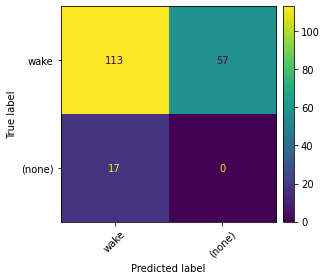

In [24]:
fig=results.plot_confusion_matrix(backend='matplotlib',)
fig.savefig('Images/IAC22/confusion_matrix.png', dpi=300)